In [ ]:
!pip install transformers==3.0.2

  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached tokenizers-0.8.1rc1.tar.gz (97 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [ ]:
pip install streamlit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import re
import string
import streamlit as st
import torch
import seaborn as sns
import transformers
import json
import logging

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from torch import cuda
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics import classification_report
logging.basicConfig(level=logging.ERROR)

In [ ]:
path_to_glove_file = "/content/glove.6B.50d.txt"
df = pd.read_excel("/content/LabeledText.xlsx")

In [ ]:
df

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...,...
4864,995.txt,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,996.txt,Feelin' the love in here! #ValentinesDay #caring,positive
4866,997.txt,#blue #eyes can't be #beaten,neutral
4867,998.txt,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


In [ ]:
print(df.shape)
print("\n",df.describe)

(4869, 3)

 <bound method NDFrame.describe of      File Name                                            Caption     LABEL
0        1.txt      How I feel today #legday #jelly #aching #gym   negative
1       10.txt  @ArrivaTW absolute disgrace two carriages from...  negative
2      100.txt  This is my Valentine's from 1 of my nephews. I...  positive
3     1000.txt  betterfeelingfilms: RT via Instagram: First da...   neutral
4     1001.txt         Zoe's first love #Rattled @JohnnyHarper15   positive
...        ...                                                ...       ...
4864   995.txt  OMG. Well done #Eskom! 'Man dies during #LoadS...  positive
4865   996.txt  Feelin' the love in here! #ValentinesDay #caring   positive
4866   997.txt                      #blue #eyes can't be #beaten    neutral
4867   998.txt              LA CHUCHA LOUUU TE CHUPO LOS OJOS..!    neutral
4868   999.txt  #colorsplash_bw #zealous Remedios #herbales y ...  positive

[4869 rows x 3 columns]>


In [ ]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 36812 word vectors.


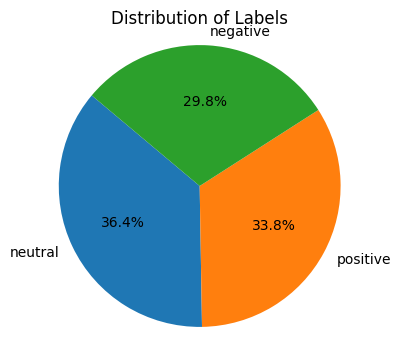

In [ ]:
# Count the frequency of each label
label_counts = df['LABEL'].value_counts()
# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

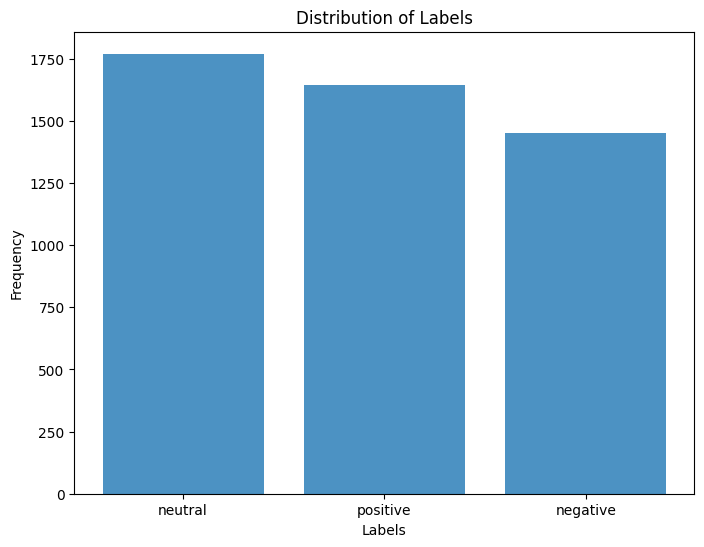

In [ ]:
# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, alpha=0.8)
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

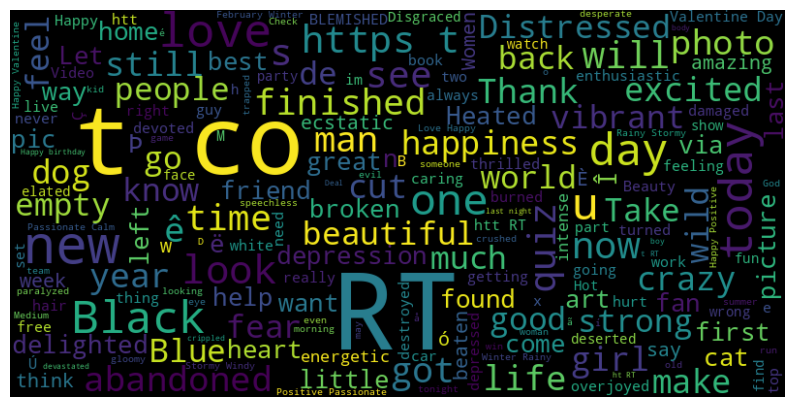

In [ ]:
from wordcloud import WordCloud
# Combine all the captions into one string
all_captions = ' '.join(df['Caption'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_captions)

# Plot the WordCloud image
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Preprocessing**

In [ ]:
def lowercase(data):
  return data['Caption'].str.lower()

def change_punctuation(data):
    return data['Caption'].str.replace('`', "'")

def remove_numbers(data):
    return data['Caption'].replace('[^a-zA-z.,!?/:;\"\'\s]', '', regex=True)

def remove_special_characters(data):
    return data['Caption'].replace('[^a-zA-Z0-9 ]', '', regex=True)

def custom(data):
    return data['Caption'].replace('im', 'i am')

nlp = spacy.load("en_core_web_sm")
def lemmatize(data):
    lemmatized_array = []

    for text in data['Caption']:
        lemmatized_text = []
        doc = nlp(text)
        for token in doc:
            lemmatized_text.append(token.lemma_)
        lemmatized_array.append(' '.join(lemmatized_text))
    return lemmatized_array

def stop_words(data):
    stop_words_array = []
    for text in data['Caption']:
        doc = nlp(text)
        filtered_tokens = [token.text for token in doc if not token.is_stop]
        stop_words_array.append(' '.join(filtered_tokens))
    return stop_words_array

def delete_links(data):
    return data['Caption'].replace(r'http\S+', '', regex=True)

def preprocessing(data):
    df['Caption'] = lowercase(df)
    df['Caption'] = custom(df)
    df['Caption'] = change_punctuation(df)
    df['Caption'] = lemmatize(df)
    df['Caption'] = remove_numbers(df)
    df['Caption'] = delete_links(df)
    df['Caption'] = remove_special_characters(df)
    return df

In [ ]:
df_copy = df.copy()
df_copy = preprocessing(df_copy)
df_copy

,File Name,Caption,LABEL
0,1.txt,how I feel today legday jelly ache gym,negative
1,10.txt,arrivatw absolute disgrace two carriage from b...,negative
2,100.txt,this be my valentine s from of my nephew I b...,positive
3,1000.txt,betterfeelingfilm rt via instagram first day...,neutral
4,1001.txt,zoe s first love rattle johnnyharper,positive
...,...,...,...
4864,995.txt,omg well do eskom man die during loadshed...,positive
4865,996.txt,feelin the love in here valentinesday care,positive
4866,997.txt,blue eye can not be beat,neutral
4867,998.txt,la chucha louuu te chupo los ojos,neutral


In [ ]:
df_copy.drop_duplicates(subset=['Caption'], inplace=True)
df_copy['Caption'] = df_copy['Caption'].astype('str')

df_copy["Caption"]

le = LabelEncoder()
df_copy['LABEL'] = le.fit_transform(df_copy['LABEL'])
df_copy

,File Name,Caption,LABEL
0,1.txt,how I feel today legday jelly ache gym,0
1,10.txt,arrivatw absolute disgrace two carriage from b...,0
2,100.txt,this be my valentine s from of my nephew I b...,2
3,1000.txt,betterfeelingfilm rt via instagram first day...,1
4,1001.txt,zoe s first love rattle johnnyharper,2
...,...,...,...
4857,989.txt,big thank you to all of the teacher who attend...,2
4858,99.txt,dave look so elated,2
4860,991.txt,completely unique petrify palm earring set...,1
4861,992.txt,rt headquarters to be fair everything make I...,0


In [ ]:
X = df_copy['Caption']
y = df_copy['LABEL']

print(X)
print("\nTarget Label:",y)

0              how I feel today  legday  jelly  ache  gym
1       arrivatw absolute disgrace two carriage from b...
2       this be my valentine s from  of my nephew  I b...
3       betterfeelingfilm  rt via instagram  first day...
4                   zoe s first love  rattle johnnyharper
                              ...                        
4857    big thank you to all of the teacher who attend...
4858                                 dave look so elated 
4860    completely  unique  petrify  palm  earring set...
4861    rt headquarters  to be fair  everything make I...
4865       feelin  the love in here   valentinesday  care
Name: Caption, Length: 4562, dtype: object

Target Label: 0       0
1       0
2       2
3       1
4       2
       ..
4857    2
4858    2
4860    1
4861    0
4865    2
Name: LABEL, Length: 4562, dtype: int64


In [ ]:
max_words = 9000
maxlen = 200
training_samples = int(len(X)*0.8)

In [ ]:
text_dataset = tf.data.Dataset.from_tensor_slices(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

max_features = 19000
embedding_dim = 128

vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=max_words, # Max number of word in the internal dictionnary. We keep the most frequent
        output_mode='int',
        output_sequence_length=maxlen  # Size max of text
        )

vectorize_layer.adapt(text_dataset.batch(64))

voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

word_index

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

Converted 4773 words (4227 misses)


**Glove, Bi- GRU architetcure and compilation**

In [ ]:
model1 = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.8), #81, 0.5
    Dense(4, activation='softmax'),
])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cl = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=9)]

**Model 1 Fitting**

In [ ]:
history = model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=150, batch_size=64, callbacks = cl)

Epoch 1/150
58/58 [==============================] - 42s 619ms/step - loss: 1.3444 - accuracy: 0.3461 - val_loss: 1.2839 - val_accuracy: 0.3417
Epoch 2/150
58/58 [==============================] - 34s 595ms/step - loss: 1.2771 - accuracy: 0.3574 - val_loss: 1.2277 - val_accuracy: 0.3384
Epoch 3/150
58/58 [==============================] - 37s 649ms/step - loss: 1.2337 - accuracy: 0.3735 - val_loss: 1.1804 - val_accuracy: 0.3505
Epoch 4/150
58/58 [==============================] - 35s 603ms/step - loss: 1.1753 - accuracy: 0.4182 - val_loss: 1.0490 - val_accuracy: 0.5181
Epoch 5/150
58/58 [==============================] - 37s 637ms/step - loss: 1.0934 - accuracy: 0.4689 - val_loss: 0.9455 - val_accuracy: 0.5367
Epoch 6/150
58/58 [==============================] - 46s 779ms/step - loss: 1.0201 - accuracy: 0.5232 - val_loss: 0.9073 - val_accuracy: 0.5345
Epoch 7/150
58/58 [==============================] - 34s 584ms/step - loss: 1.0732 - accuracy: 0.4673 - val_loss: 0.9013 - val_accuracy:

<Axes: >

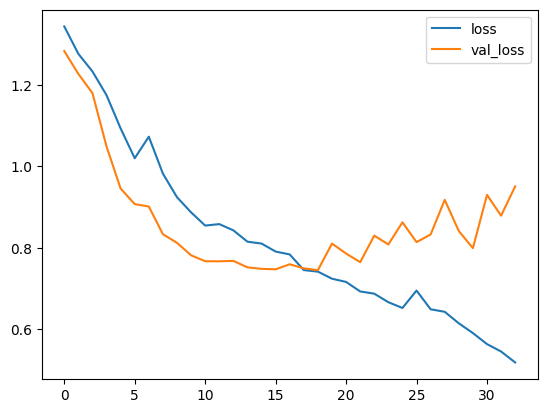

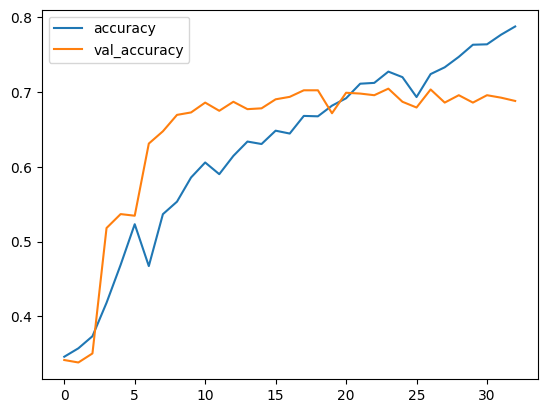

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
print("\n")
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

**Model 1 Evaluation**

In [ ]:
predictions = model1.predict(X_valid)
predicted_labels = np.argmax(predictions, axis=1)

accu = accuracy_score(predicted_labels, y_valid)
pre = precision_score(predicted_labels, y_valid,average = "weighted")
f1 = f1_score(predicted_labels, y_valid,average = "weighted")
print("Accuracy:",accu)
print("\nPrecision:",pre)
print("\nF1-Score:",f1)

29/29 [==============================] - 3s 74ms/step
Accuracy: 0.7042716319824753

Precision: 0.7166289534294115

F1-Score: 0.7055075744334404


**RoBERTa**

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
train = pd.read_excel("/content/LabeledText.xlsx")

In [ ]:
new_df = train[['Caption', 'LABEL']]
new_df

,Caption,LABEL
0,How I feel today #legday #jelly #aching #gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive
3,betterfeelingfilms: RT via Instagram: First da...,neutral
4,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...
4864,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,Feelin' the love in here! #ValentinesDay #caring,positive
4866,#blue #eyes can't be #beaten,neutral
4867,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


**Parameters**

In [ ]:
MAX_LEN = 245
TRAIN_BATCH_SIZE = 5
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Caption
        self.targets = self.data.LABEL.map({'positive': 0, 'neutral': 1, 'negative': 2})  # Map labels to integers
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Updated padding argument
            truncation= True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)  # Use torch.long for integer targets
        }

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=150) #200 was here
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [ ]:
print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

FULL Dataset: (4869, 2)
TRAIN Dataset: (3895, 2)
TEST Dataset: (974, 2)


In [ ]:
training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model2 = RobertaClass()
model2.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model2.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

**RoBERTa Training Function definition**

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model2.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model2(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

**Model Training**

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Training Loss per 5000 steps: 1.6529887914657593
Training Accuracy per 5000 steps: 20.0


779it [2:47:57, 12.94s/it]

The Total Accuracy for Epoch 0: 56.63671373555841
Training Loss Epoch: 0.9356730839330822
Training Accuracy Epoch: 56.63671373555841


**RoBERTa - Validation**

In [ ]:
predictions_model2 = []

In [ ]:
def valid(model, testing_loader):
    model2.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model2(ids, mask, token_type_ids).squeeze()
            predictions_model2.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    print(outputs)

    return epoch_accu

**RoBERTa Val Accuracy**

In [ ]:
acc = valid(model2, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

1it [00:02,  2.96s/it]

Validation Loss per 100 steps: 0.5305789709091187
Validation Accuracy per 100 steps: 75.0


244it [13:25,  3.30s/it]

Validation Loss Epoch: 0.6674423485872198
Validation Accuracy Epoch: 70.63655030800821
tensor([[ 3.2613,  1.3474, -0.4769, -2.5747, -2.6365],
        [ 0.1514,  1.4885,  2.6600, -3.0274, -3.2118]])
Accuracy on test data = 70.64%


In [ ]:
import numpy as np

# Pad predictions_model1 to match the size of predictions_model2
max_samples = max(len(predictions), len(predictions_model2))
padded_predictions_model1 = np.pad(predictions, (0, max_samples - len(predictions)), mode='constant')

# Combine padded predictions into a feature matrix
combined_predictions = np.column_stack((padded_predictions_model1, predictions_model2))

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Adjust target labels to match the size of combined_predictions
y_valid_adjusted = np.pad(y_valid, (0, max_samples - len(y_valid)), mode='constant')

# Train the meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(combined_predictions, y_valid_adjusted)

# Make predictions using the meta-learner
meta_predictions = meta_learner.predict(combined_predictions)

# Evaluate the performance of the meta-learner
meta_accuracy = accuracy_score(y_valid_adjusted, meta_predictions)
print("Meta-Learner Accuracy:", meta_accuracy)

Meta-Learner Accuracy: 0.7207392197125256


In [ ]:
predicted_sentiments = le.inverse_transform(meta_predictions)
print("Predicted Sentiments:", predicted_sentiments)

Predicted Sentiments: ['positive' 'positive' 'positive' 'positive' 'positive' 'neutral'
 'negative' 'positive' 'positive' 'neutral' 'neutral' 'positive'
 'negative' 'neutral' 'negative' 'negative' 'negative' 'neutral'
 'positive' 'neutral' 'negative' 'negative' 'negative' 'negative'
 'negative' 'neutral' 'positive' 'positive' 'negative' 'positive'
 'neutral' 'negative' 'neutral' 'neutral' 'neutral' 'positive' 'positive'
 'negative' 'negative' 'negative' 'positive' 'negative' 'negative'
 'positive' 'neutral' 'negative' 'negative' 'negative' 'positive'
 'negative' 'positive' 'negative' 'negative' 'negative' 'positive'
 'negative' 'positive' 'neutral' 'negative' 'neutral' 'neutral' 'positive'
 'neutral' 'positive' 'negative' 'negative' 'negative' 'positive'
 'negative' 'neutral' 'negative' 'neutral' 'positive' 'positive' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'positive' 'negative' 'neutral'
 'neutral' 'positive' 'neutral' 'negative' 'negative' 'negative'
 'negative' 'negative'

In [ ]:
from collections import Counter

sentiment_counts = Counter(predicted_sentiments)
final_sentiment = sentiment_counts.most_common(1)[0][0]

print("Final Sentiment:", final_sentiment)

Final Sentiment: negative


**Chat History**

In [ ]:
chat = "/content/WhatsApp Chat.txt"

In [ ]:
from collections import defaultdict

In [ ]:
fc = "/content/WhatsApp Chat.txt"

In [ ]:
import re
from collections import defaultdict

def extract_english_words(text):
    english_words = []
    # Regular expression pattern to match English words
    english_pattern = re.compile(r'\b[a-zA-Z]+\b')
    # Find all English words in the text
    english_words = english_pattern.findall(text)
    return english_words

def process_whatsapp_file(file_path):
    user_messages = defaultdict(list)
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the lines of the WhatsApp chat history file
        lines = file.readlines()

    current_user = None
    for line in lines:
        # Split each line by the timestamp and sender's name
        parts = line.split(' - ')
        if len(parts) > 1:
            user_message = parts[1].strip()  # Extract the user name and message content
            user_parts = user_message.split(': ')
            if len(user_parts) > 1:
                user = user_parts[0].strip()  # Extract the user name
                message = ': '.join(user_parts[1:]).strip()  # Reconstruct the message part

                # Check if the user has changed
                if user != current_user:
                    # If the user has changed, reset the current_user variable
                    current_user = user
                    # Initialize an empty list for the user if it's the first message from that user
                    if not user_messages[current_user]:
                        user_messages[current_user] = []

                # Extract English words from the message and add them to the corresponding user's list
                english_words = extract_english_words(message)
                user_messages[current_user].extend(english_words)

    return user_messages

# Path to your WhatsApp chat history file
whatsapp_file_path = fc

# Process the WhatsApp chat history file
user_messages = process_whatsapp_file(whatsapp_file_path)

# Print the dictionaries along with the corresponding user names
for user, messages in user_messages.items():
    print(f"User: {user}")
    print(f"messages: {messages}\n")

User: Karthi
messages: ['Dei', 'group', 'paaru', 'Media', 'omitted', 'https', 'www', 'qburst', 'com', 'en', 'in', 'software', 'testing', 'services', 'text', 'Our', 'QA', 'we', 'null', 'Vella', 'iruka', 'haleem', 'sollu', 'Naa', 'privacy', 'pathi', 'patha', 'Topic', 'Hlo', 'Itha', 'vachu', 'edhavadhu', 'panalama', 'Or', 'unakku', 'ehavadhu', 'idea', 'kedachuda', 'https', 'ieeexplore', 'ieee', 'org', 'document', 'En', 'pa', 'Oh', 'ho', 'Antha', 'chatpdf', 'eh', 'kojam', 'idea', 'kamchidu', 'appo', 'ippo', 'load', 'aagala', 'I', 'think', 'so', 'naa', 'confirm', 'pannitu', 'solra', 'Ab', 'okay', 'null', 'Text', 'Based', 'Emotional', 'Wellbeing', 'Monitoring', 'null', 'Yes', 'Python', 'enakku', 'teriyum', 'c', 'unakku', 'twrinja', 'okay', 'Python', 'Idea', 'va', 'Ama', 'Only', 'one', 'antha', 'text', 'monitoring', 'atula', 'privacy', 'ensure', 'panra', 'maari', 'Athoda', 'Apps', 'paatundu', 'iruken', 'Inno', 'illa', 'patutu', 'iruka', 'Un', 'idea', 'ku', 'Seri', 'pakara', 'Seri', 'mudinja',

In [ ]:
messages1 = user_messages["Karthi"]
messages2 = user_messages["Haleem Cres"]

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=maxlen
)

# Adapt the layer to the new messages
vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices([" ".join(messages1)]).batch(1))

# Convert the messages into numerical vectors
message_vectors = vectorize_layer([" ".join(messages)])

# Add a batch dimension to the message vectors
message_vectors = tf.expand_dims(message_vectors, axis=0)
message_vectors = tf.reshape(message_vectors, (1, 200))

In [ ]:
message_vectors

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[  1,   1,   4,   4, 198,   1,   1, 433,   1,  67,   1, 444, 112,
          1, 234,  74,   1, 103,  38, 444,   1, 907,  99,   1,  10,   1,
          1,   1,   1,   1, 955,   1,   1,  90, 100,   1,  12,  25,  51,
        110,   1, 112,  37,   1,   1,   1, 157,  12, 165,  10,   1, 896,
        896,  74,  38, 412,   1,   1,   1,  38,  38,  43, 677,   1,  60,
        883,  43, 677,   1,  60, 883,  43, 677,   1,  60, 883,  95,   1,
         40,   1, 442,  52, 472,   1, 748,  12,   1,   1, 335,  10,   1,
         71,  71,  43, 744, 745, 621, 318,  43, 744, 745, 621, 318,  43,
        744, 745, 621, 318,  43, 744, 745, 621, 318,   1, 907,  99,   1,
          1,  99,  12,  71,   1,   1, 677,   1,   1,   1,   1,   1,   1,
        402, 101,  32, 402,  10,  25,   1, 689,   1,   1,   1,  10,   1,
          1, 388,   1,  25,  38,   1,  25,  25,   1, 108,   1,   1, 907,
         99,  85, 677,  12,   1,  38,   1,   1,   1, 188,   1,   1,   1,
   

In [ ]:
try:
    # Use the model to predict the sentiment of the messages
    predictions = model1.predict(message_vectors)

    # Get the predicted sentiment labels
    predicted_labels = np.argmax(predictions, axis=1)

    print(f"Predicted sentiment label: {predicted_labels[0]}")
except Exception:
  predictions = 0
  predicted_labels = np.argmax(predictions)
  print(f"Predicted sentiment label: {predicted_labels}")

Predicted sentiment label: 0


In [ ]:
0

0